In [44]:
import sys
sys.path.append('../30_data_tools/')
sys.path.append('../60_gebastel/Model/')

import sqlite3
import pandas as pd
from tqdm.auto import tqdm
from helper import load_dotenv
from file_interaction import get_related_filepath, open_img
from classification_tools import preclassifier, cut_img_into_tiles
import plotly.express as px

In [47]:
from load_constants import load_colors

In [48]:
colors = load_colors()

In [2]:
dotenv = load_dotenv()

In [3]:
with sqlite3.connect( dotenv['DB_PATH'] ) as con:
    data = pd.read_sql(
        '''
            SELECT * FROM related_file rf 
            WHERE job='24-03-05-01_randomTrainPages' AND variant_name = 'ps2400dpi150lpi' AND "type" = '4c_600' 
        ''',
        con
    )

In [35]:
sample = data.sample(n=250)

In [36]:
out = []

for i in tqdm(range(sample.shape[0])):
    row = sample.iloc[i]

    filepath = get_related_filepath(
        row.job,
        row.variant_name,
        f'{ row.pdf_filename }.{ row.type }.jpg'
    )
    img = open_img( filepath )
    tiles = cut_img_into_tiles( img )
    tiles_filtered = preclassifier( tiles )

    out.append((
        row.name,
        len(tiles),
        len(tiles_filtered)
    ))

  0%|          | 0/250 [00:00<?, ?it/s]

/Users/frederic.birwe/Library/Python/3.10/lib/python/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (94996353 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/frederic.birwe/Library/Python/3.10/lib/python/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (119990970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/frederic.birwe/Library/Python/3.10/lib/python/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115387158 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/frederic.birwe/Library/Python/3.10/lib/python/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (94735298 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [42]:
results = pd.DataFrame(out, columns=['data_idx','tiles_found','tiles_filtered'])
results.loc[
    :,
    'filtered_share'
] = 1 - (results.tiles_filtered / results.tiles_found)

results

,data_idx,tiles_found,tiles_filtered,filtered_share
0,946,1394,847,0.392396
1,525,1599,1418,0.113196
2,351,1394,790,0.433286
3,406,899,323,0.640712
4,1687,1616,744,0.539604
...,...,...,...,...
245,1204,1682,1564,0.070155
246,1707,1289,496,0.615206
247,259,1535,498,0.675570
248,1189,1649,1452,0.119466


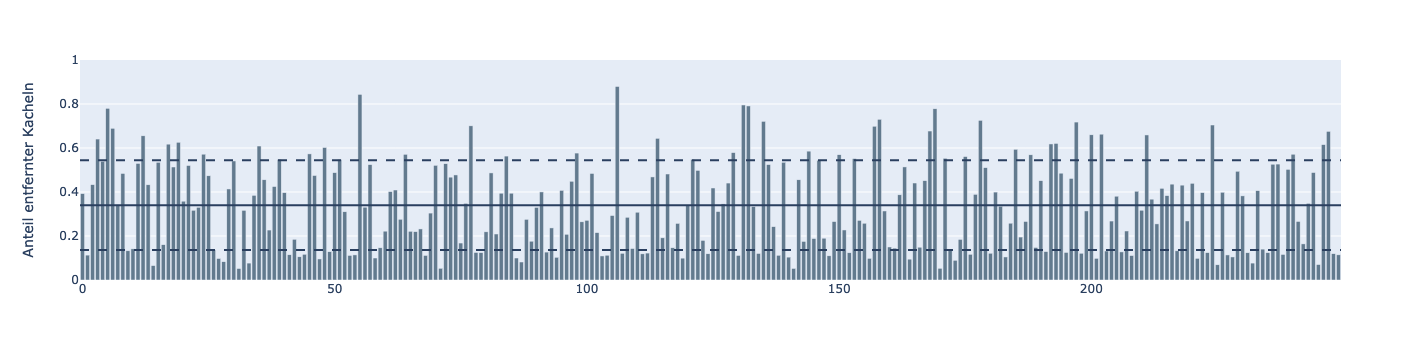

In [65]:
fig = px.bar(
    results.filtered_share,
    color_discrete_sequence=colors['COLOR_SEQUENCE'],
    labels={
        'index' : '',
        'value' : 'Anteil entfernter Kacheln'
    }
)
fig.add_hline(y=results.filtered_share.mean())
fig.add_hline(y=results.filtered_share.mean() - results.filtered_share.std(), line_dash="dash")
fig.add_hline(y=results.filtered_share.mean() + results.filtered_share.std(), line_dash="dash")

fig.update_layout(yaxis_range=[0,1])
fig.update_layout(showlegend=False)
#fig.update_xaxes(showticklabels=False)

fig.write_image( dotenv['ATTACHMENT_DIR'] / 'klassifizierungsmodell' / 'anteil_gefilterter_kacheln.jpg' )

fig

In [63]:
results.filtered_share.mean(), results.filtered_share.std()

(0.34032156807895997, 0.2034636217893017)